## Objective
This notebook investigates whether model performance is limited by training data size or feature expressiveness. Specifically, we analyze how cross-validation RMSE changes as a function of training set size.

We compare:
1. RDKit baseline descriptors
2. RDKit + polymer-aware descriptors

## Experiment Setup

Model: Random Forest (same hyperparameters as baseline)

Preprocessing: clip → impute → variance threshold

Cross-validation: 5-fold

Metric: RMSE

Train size grid: 20% → 100%

This experiment isolates data size effects without changing the model configuration.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve

In [20]:
train_sizes = np.linspace(0.2, 1.0, 5)

In [21]:
meta_cols = ["SMILES", "Tg", "PID", "Polymer Class"]
df = pd.read_csv("../data/intermediate/tg_with_rdkit_descriptors.csv")
y = df["Tg"]
x = df.drop(columns=meta_cols)

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

NAN_THRESHOLD = 0.8
RANDOM_SEED = 42
N_ESTIMATORS = 200
VAR_THRESHOLD = 1e-5
CLIP_VALUE = 1e6

nan_ratio = x.isna().mean()
cols_to_keep = nan_ratio[nan_ratio < NAN_THRESHOLD].index
x = x[cols_to_keep]

clipper = FunctionTransformer(lambda X: np.clip(X, -CLIP_VALUE, CLIP_VALUE), 
                              feature_names_out="one-to-one")

baseline_pipeline = Pipeline(
    [("clip", clipper),
     ("impute", SimpleImputer(strategy="median")),
     ("var", VarianceThreshold(threshold=VAR_THRESHOLD)), 
     ("rf", RandomForestRegressor(
         n_estimators=N_ESTIMATORS, 
         random_state=RANDOM_SEED
         ))
    ])

In [23]:
from sklearn.model_selection import KFold

cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_SEED
)

In [24]:
train_sizes_abs, train_scores, val_scores = learning_curve(
    baseline_pipeline,
    x,
    y,
    train_sizes=train_sizes,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

val_rmse_mean = -val_scores.mean(axis=1)
val_rmse_std = val_scores.std(axis=1)

In [34]:
df_polymer = pd.read_csv("../data/intermediate/tg_with_rdkit_and_polymer_features.csv")
x_polymer = df_polymer.drop(columns=meta_cols)
y_polymer = df_polymer["Tg"]

In [35]:
nan_ratio_poly = x_polymer.isna().mean()
cols_to_keep_poly = nan_ratio_poly[nan_ratio_poly < NAN_THRESHOLD].index
x_polymer = x_polymer[cols_to_keep_poly]

In [36]:
train_sizes_abs_p, train_scores_p, val_scores_p = learning_curve(
    baseline_pipeline,
    x_polymer,
    y_polymer,
    train_sizes=train_sizes,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

val_rmse_mean_p = -val_scores_p.mean(axis=1)
val_rmse_std_p = val_scores_p.std(axis=1)

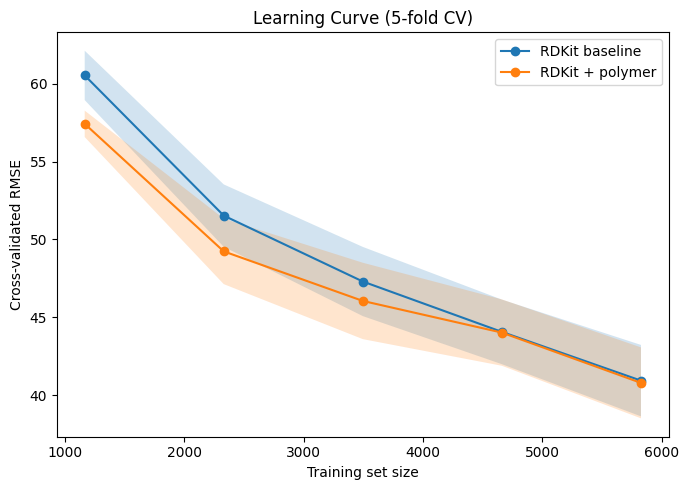

In [37]:
plt.figure(figsize=(7,5))

# RDKit baseline
plt.plot(train_sizes_abs, val_rmse_mean, marker="o", label="RDKit baseline")
plt.fill_between(
    train_sizes_abs,
    val_rmse_mean - val_rmse_std,
    val_rmse_mean + val_rmse_std,
    alpha=0.2
)

# RDKit + polymer
plt.plot(train_sizes_abs_p, val_rmse_mean_p, marker="o", label="RDKit + polymer")
plt.fill_between(
    train_sizes_abs_p,
    val_rmse_mean_p - val_rmse_std_p,
    val_rmse_mean_p + val_rmse_std_p,
    alpha=0.2
)

plt.xlabel("Training set size")
plt.ylabel("Cross-validated RMSE")
plt.title("Learning Curve (5-fold CV)")
plt.legend()
plt.tight_layout()
plt.show()

Learning curve analysis reveals that Tg prediction remains data-limited, with performance continuing to improve at the largest training size. Polymer-aware descriptors provide modest improvements in low-data regimes, suggesting that they encode useful prior knowledge. However, as training size increases, the performance gap diminishes, indicating that generic molecular descriptors capture the dominant structure–property relationships when sufficient data are available.

In [38]:
baseline_pipeline.fit(x_polymer, y_polymer)

rf = baseline_pipeline.named_steps["rf"]
importances = rf.feature_importances_

var_selector = baseline_pipeline.named_steps["var"]

selected_features = baseline_pipeline[:-1].get_feature_names_out()

importance_df = (
    pd.DataFrame({
        "feature": selected_features,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)

In [39]:
importance_df.head(20)

,feature,importance
202,rotatable_bond_frac,0.578119
115,RingCount,0.082021
16,BertzCT,0.031350
29,HallKierAlpha,0.025999
91,FractionCSP3,0.018619
147,fr_aniline,0.011270
81,VSA_EState1,0.008169
85,VSA_EState4,0.008000
58,SlogP_VSA1,0.007874
196,frac_N,0.007829


In [41]:
polymer_features = ["frac_C", "frac_O", "frac_N", "frac_S", "frac_hetero", 
                    "aromatic_ring_count", "aromatic_atom_frac", "double_bond_count", 
                            "rotatable_bond_frac", "heavy_atom_count"]

polymer_cols = [col for col in x_polymer.columns if col in polymer_features]

In [42]:
polymer_importance = importance_df[
    importance_df["feature"].isin(polymer_cols)
]["importance"].sum()

rdkit_importance = importance_df[
    ~importance_df["feature"].isin(polymer_cols)
]["importance"].sum()

print("Total polymer importance:", polymer_importance)
print("Total RDKit importance:", rdkit_importance)

Total polymer importance: 0.5970317601279166
Total RDKit importance: 0.4029682398720833


Although polymer-aware descriptors constitute a small fraction of the feature space, they account for nearly 60% of the total model importance. This indicates that polymer-specific features encode highly concentrated predictive information for Tg, despite their limited dimensionality.

In [43]:
polymer_avg = polymer_importance / len(polymer_cols)
rdkit_avg = rdkit_importance / (len(x_polymer.columns) - len(polymer_cols))

In [45]:
print("Polymer avg importance:", polymer_avg)
print("RDKit avg importance:", rdkit_avg)

Polymer avg importance: 0.05970317601279166
RDKit avg importance: 0.0019656987310833333


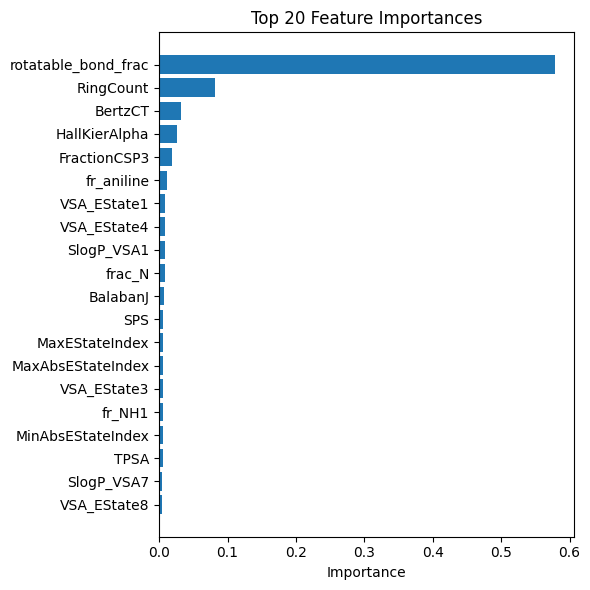

In [44]:
top_n = 20
plt.figure(figsize=(6,6))
plt.barh(
    importance_df.head(top_n)["feature"][::-1],
    importance_df.head(top_n)["importance"][::-1]
)
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

Although polymer-aware descriptors constitute only a small fraction of the total feature space, they account for nearly 60% of the overall model importance. On average, a single polymer-specific feature is approximately 30 times more influential than an individual RDKit descriptor. This suggests that polymer-aware features encode highly concentrated predictive information for Tg, even though their marginal performance improvement appears modest in cross-validation.

## Experiment: Test whether "Polymer-aware descriptors provide stronger inductive bias in small-data regimes."

In [46]:
from sklearn.model_selection import train_test_split

X_small, _, y_small, _ = train_test_split(
    x_polymer,
    y_polymer,
    train_size=0.3,
    random_state=42
)

In [47]:
baseline_pipeline.fit(X_small, y_small)

rf_small = baseline_pipeline.named_steps["rf"]
importances_small = rf_small.feature_importances_

var_selector_small = baseline_pipeline.named_steps["var"]
mask_small = var_selector_small.get_support()

selected_features_small = X_small.columns[mask_small]

importance_df_small = (
    pd.DataFrame({
        "feature": selected_features_small,
        "importance": importances_small
    })
    .sort_values("importance", ascending=False)
)

In [48]:
polymer_importance_small = importance_df_small[
    importance_df_small["feature"].isin(polymer_cols)
]["importance"].sum()

rdkit_importance_small = importance_df_small[
    ~importance_df_small["feature"].isin(polymer_cols)
]["importance"].sum()

print("Small data polymer total:", polymer_importance_small)
print("Small data RDKit total:", rdkit_importance_small)

Small data polymer total: 0.5976586893336656
Small data RDKit total: 0.4023413106663346


In [49]:
polymer_avg_small = polymer_importance_small / len(polymer_cols)
rdkit_avg_small = rdkit_importance_small / (
    len(selected_features_small) - len(polymer_cols)
)

print("Small data polymer avg:", polymer_avg_small)
print("Small data RDKit avg:", rdkit_avg_small)

Small data polymer avg: 0.059765868933366564
Small data RDKit avg: 0.002174817895493701


Polymer features encode highly concentrated predictive signal across data regimes, but their marginal performance gain diminishes as global molecular descriptors accumulate sufficient statistical power.

## Phase 2 Summary

The baseline Random Forest model achieves stable cross-validated performance (RMSE ≈ 41 K). Incorporating polymer-aware descriptors yields only marginal performance improvement within CV uncertainty. However, learning curve analysis reveals that the problem remains data-limited, with performance continuing to improve at larger training sizes.

Feature importance analysis demonstrates that polymer-aware descriptors account for nearly 60% of total model importance, despite representing a small fraction of the feature space. On average, a single polymer-specific feature is approximately 30 times more influential than an individual RDKit descriptor. This suggests that polymer-aware descriptors encode highly concentrated structural information for Tg prediction, although their marginal performance gain diminishes as generic molecular descriptors accumulate statistical power.